# King County Housing Sales Project

## Overview

For this project, we use a multiple linear regression model to analyze house sales in King County, a large county located in the State of Washington. Within the notebook, you will see how we iterate upon the data and come to our final model.

## Business Problem

How can we help identify price dislocation in Washington King County based on certain housing features. To examine pricing in the area we are analyzing recent sales data (2021 - 2022).

## Data Understanding

This project uses the King County House Sales dataset, which can be found in kc_house_data.csv in the data folder of this project's GitHub repository. The description of the column names can be found in column_names.md in the same folder. The dataset was pulled from 

### IMPORTS AND DATA

In [161]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#### Reading the csv into a DataFrame

In [162]:
houses = pd.read_csv('data/kc_house_data.csv')

In [163]:
display(houses.head())
display(houses.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,"675,000.00",4,1.00,1180,7140,1.00,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.46,-122.19
1,8910500230,12/13/2021,"920,000.00",5,2.50,2770,6703,1.00,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.71,-122.36
2,1180000275,9/29/2021,"311,000.00",6,2.00,2880,6156,1.00,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.50,-122.23
3,1604601802,12/14/2021,"775,000.00",3,3.00,2160,1400,2.00,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.57,-122.29
4,8562780790,8/24/2021,"592,500.00",2,2.00,1120,758,2.00,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.53,-122.07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

None

# Initital comments on the Dataframe
- We can see that heat_source and sewer_system have null values, initial thoughts were to remove the nulls associated with these rows. As we further investigate below we realized that this would not be necessary as they will be removed regardless.

Define function

In [164]:
def city(address):
    """
    A function that takes the entry in the 'address' column, which is a string, and
    returns the city in a string.
    """
    address_list = address.split(',')
    if len(address_list) == 6:
        city = address_list[3].strip()
    elif len(address_list) == 5:
        city = address_list[2].strip()
    else:
        city = address_list[1].strip()
    return city

def state(address):
    """
    A function that takes the entry in the 'address' column, which is a string, and
    returns the state in a string.
    """
    address_list = address.split(',')
    if len(address_list) == 6:
        statezip = address_list[4].split()
    elif len(address_list) == 5:
        statezip = address_list[3].split()
    else:
        statezip = address_list[2].split()
        
    if len(statezip) > 2:
        state = statezip[0] + ' ' + statezip[1]
    else:
        state = statezip[0]
    return state

def zipcode(address):
    """
    A function that takes the entry in the 'address' column, which is a string, and
    returns the zipcode in a string.
    """
    address_list = address.split(',')
    zipcode = address_list[-2].split()[-1]
    return zipcode

In [165]:
"""
We're applying the above functions to the Dataframe via a .map and creating a new column for
each respective category. 

The new columns are: city, zipcode, and state.
"""

houses['city'] = houses['address'].map(city)
houses['zipcode'] = houses['address'].map(zipcode)
houses['state'] = houses['address'].map(state)

In [166]:
"""
Changing date to datetime and then creating a separate column for year
"""
houses['date'] = pd.to_datetime(houses['date'], infer_datetime_format=True)

"""
Making a 'yr_sold' column using the year from 'date'
"""
houses['yr_sold'] = pd.to_datetime(houses['date'], infer_datetime_format=True).dt.year

# Observations about Correlations between variables

- Below you can observe that 'sqft_living' has the highest correlation with 'price' at 0.61. Based on this we will have our first baseline simple linear regression be between 'price and 'sqft_living'.
- Another observation below is that all the 'sqft_' seem to be highly correlated which can cause us multicollinearity. Before dropping any variables, we are going to run all of them as a regression with 'price' to see how high their R^2 are independently.

In [167]:
"""
Looking at the correlation between all variables to see which ones have the strongest corr
with variable 'price'.
"""
houses.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,yr_sold
id,1.00,-0.03,-0.01,-0.01,-0.03,-0.12,0.03,-0.02,-0.01,-0.01,-0.04,0.02,-0.03,-0.00,0.00,-0.01
price,-0.03,1.00,0.29,0.48,0.61,0.09,0.18,0.54,0.25,0.26,0.31,0.10,0.08,0.06,-0.02,0.07
bedrooms,-0.01,0.29,1.00,0.59,0.64,0.00,0.15,0.55,0.24,0.32,0.18,0.15,0.01,0.11,-0.11,-0.03
bathrooms,-0.01,0.48,0.59,1.00,0.77,0.04,0.40,0.67,0.26,0.46,0.33,0.44,0.04,-0.01,0.02,-0.04
sqft_living,-0.03,0.61,0.64,0.77,1.00,0.12,0.30,0.88,0.34,0.51,0.40,0.29,0.04,0.10,-0.09,-0.03
sqft_lot,-0.12,0.09,0.00,0.04,0.12,1.00,-0.03,0.13,0.00,0.09,0.16,0.00,0.01,0.03,-0.03,-0.00
floors,0.03,0.18,0.15,0.40,0.30,-0.03,1.00,0.45,-0.25,0.13,0.13,0.54,-0.03,-0.22,0.23,-0.02
sqft_above,-0.02,0.54,0.55,0.67,0.88,0.13,0.45,1.00,-0.07,0.56,0.31,0.39,0.01,0.09,-0.08,-0.02
sqft_basement,-0.01,0.25,0.24,0.26,0.34,0.00,-0.25,-0.07,1.00,0.03,0.21,-0.23,0.05,0.06,-0.05,-0.01
sqft_garage,-0.01,0.26,0.32,0.46,0.51,0.09,0.13,0.56,0.03,1.00,0.22,0.45,-0.10,0.09,-0.10,-0.01


# Data Cleaning

- After checking the value_counts() for state, we've realized that there are many states besides Washington. Since our focus is just in Washington, we've decided to remove any other state that is not Washington.
- Then we wanted to make sure that we did not have any duplicate values, so we checked our 'id'. Upon further review we realized that we had exactly one duplicate and decided to remove it.

In [ ]:
clean_houses['state'].value_counts()

In [168]:
clean_houses = houses.loc[houses['state'] == 'Washington']
clean_houses.drop_duplicates(subset=['id'], inplace=True)

<ipython-input-168-d8f60f4d9dbb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_houses.drop_duplicates(subset=['id'], inplace=True)


In [169]:
#sanity check
clean_houses['state'].value_counts()

Washington    29244
Name: state, dtype: int64

In [170]:
clean_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29244 entries, 0 to 30154
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             29244 non-null  int64         
 1   date           29244 non-null  datetime64[ns]
 2   price          29244 non-null  float64       
 3   bedrooms       29244 non-null  int64         
 4   bathrooms      29244 non-null  float64       
 5   sqft_living    29244 non-null  int64         
 6   sqft_lot       29244 non-null  int64         
 7   floors         29244 non-null  float64       
 8   waterfront     29244 non-null  object        
 9   greenbelt      29244 non-null  object        
 10  nuisance       29244 non-null  object        
 11  view           29244 non-null  object        
 12  condition      29244 non-null  object        
 13  grade          29244 non-null  object        
 14  heat_source    29214 non-null  object        
 15  sewer_system   2923

In [171]:
def Rsquaredcomp(dataframe,target_str,comp_list):
    """
    This is a function that returns a dataframe which lists
    all the R^2 for all the chosen variables.
    
    dataframe -> the dataframe that will be used to run the regression
    
    target_str -> the string name of the target variable/column to be predicted
    
    comp_list -> a list of strings of the variables/columns that will be individually
                    used to predict 'price'.
    """
    Rsquared = []
    for i in comp_list:
        y = dataframe[target_str]
        X = dataframe[i]
        simple_model = sm.OLS(endog=y, exog=sm.add_constant(X))
        simple_model_results = simple_model.fit()
        r2 = simple_model_results.rsquared
        Rsquared.append(r2)
    
    df = pd.DataFrame(np.array(Rsquared),index=comp_list,columns=["Rsquared"])
    return df

In [172]:
"""
Running the function above to clearly compare which of the numeric variables have the
highest R^2.
"""

comp = ['floors','bedrooms','bathrooms','floors','sqft_living', 'sqft_above','sqft_basement',
        'sqft_garage','sqft_patio', 'sqft_lot',
        'yr_built', 'yr_renovated','lat','long']
Rsquaredcomp(clean_houses,'price',comp)

,Rsquared
floors,0.04
bedrooms,0.08
bathrooms,0.24
floors,0.04
sqft_living,0.38
sqft_above,0.30
sqft_basement,0.06
sqft_garage,0.07
sqft_patio,0.10
sqft_lot,0.01


## Simple Regression (Baseline)
We will explore our target (price) with the variable with the strongest correlation which is sqft_living

In [173]:
# setting our alpha
alpha = 0.05

In [174]:
y = clean_houses['price']
X = clean_houses[['sqft_living']]

base_model = sm.OLS(endog=y, exog=sm.add_constant(X))
base_results = base_model.fit()
base_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.794e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:41:34   Log-Likelihood:            -4.3529e+05
No. Observations:               29244   AIC:                         8.706e+05
Df Residuals:                   29242   BIC:                         8.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.091e+04   9885.550     -9.196      0.000    -1.1e+05   -7.15e+04
sqft_living   564.8352      4.217    133.933      0.000     556.569     573.101
==============================================================================
Omnibus:                    42311.944   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50086865.110
Skew:                           8.231   Prob(JB):                         0.00
Kurtosis:                     205.075   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our base model of housing prices and sqft living gives us a R^2 of .38. We know this model is significant becasue p_value for the f-statistic is below our alpha. We can interpret our coefficient for sqft living as: For every unit increase in sqft living, there is an increase on average of $564.84 USD in price. 

### Checking our assumptions
1. linearity
2. Normality
3. Independence 
4. Homoskedasticity

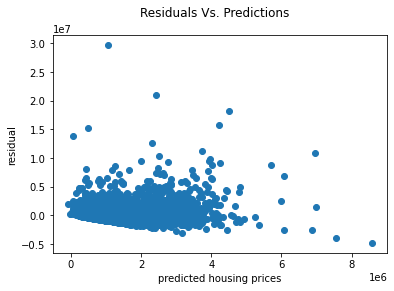

In [175]:
model_preds = base_results.predict(sm.add_constant(X))
# resid = error (differecne from real points (y) to predict points (preds))
resids = y - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('predicted housing prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');

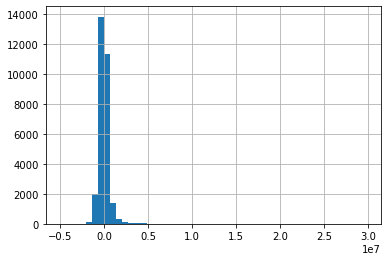

In [176]:
resids.hist(bins=50);

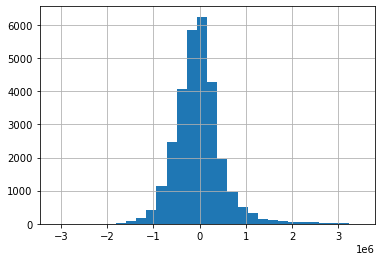

In [177]:
# To eliminate the outliers from the plot we might try zooming in on the center:
resids[abs(resids) < 3500000].hist(bins=30);

In [178]:
#fig, ax = plt.subplots()
#ax.scatter(y_scld, resids);

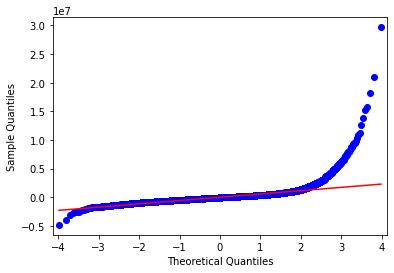

In [179]:
sm.qqplot(resids, line='r');

## Transforming our target (price)
We saw from our histogram of price it was very right skewed and so by taking the natural log, we will improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve.

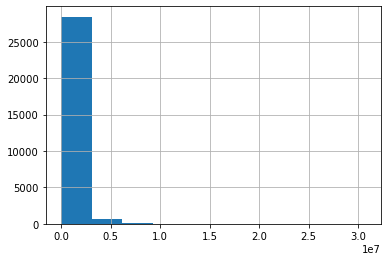

In [180]:
y.hist();

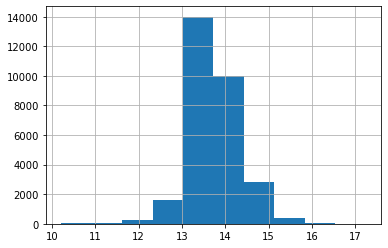

In [181]:
y_scld = np.log(y)
y_scld.hist();

In [182]:
# Improved simple regression (baseline) after transforming our target
X = clean_houses[['sqft_living']]

base_model_scld = sm.OLS(endog=y_scld, exog=sm.add_constant(X))
base_results_scld = base_model_scld.fit()
base_results_scld.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                 1.870e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:41:35   Log-Likelihood:                -18636.
No. Observations:               29244   AIC:                         3.728e+04
Df Residuals:                   29242   BIC:                         3.729e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9398      0.006   2015.900      0.000      12.927      12.952
sqft_living     0.0004   2.74e-06    136.741      0.000       0.000       0.000
==============================================================================
Omnibus:                     5809.043   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45229.479
Skew:                          -0.745   Prob(JB):                         0.00
Kurtosis:                       8.907   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Further exploration of data
- Testing different multi-linear regressions to see which variables we want to keep.
- We ran all the categorical variables with sqft_living and decided that we should only keep 'bedrooms','bathrooms', 'sqft_living','view','grade','zipcode', and 'yr_sold'
    - We're keeping these variables because after we ran the multiple linear regressions with sqft_living they returned the highest increase in R^2.

In [184]:
# finding the median price of houses for each grade

clean_houses.groupby('grade').median()['price'].sort_values()

grade
2 Substandard                       302,500.00
3 Poor                              400,000.00
4 Low                               470,000.00
5 Fair                              500,000.00
6 Low Average                       575,000.00
7 Average                           750,000.00
8 Good                              950,000.00
1 Cabin                           1,352,500.00
9 Better                          1,499,950.00
10 Very Good                      2,180,000.00
11 Excellent                      2,950,000.00
12 Luxury                         3,850,000.00
13 Mansion                        6,199,000.00
Name: price, dtype: float64

In [185]:
cat_grd_df = clean_houses[[‘price’,‘sqft_living’,‘grade’]]
cat_grd_df = pd.get_dummies(cat_grd_df,columns=[‘grade’],prefix=‘grd’)


#Dropping most frequent
cat_grd_df.drop(columns=[‘grd_13 Mansion’,‘price’],axis=1,inplace=True)
testdf_model = sm.OLS(endog=y, exog=sm.add_constant(cat_grd_df))
testdf_results = testdf_model.fit()
testdf_results.summary()

In [186]:
# finding the median price of houses for each zipcode

clean_houses.groupby('zipcode').median()['price'].sort_values()

zipcode
98224                       226,000.00
98422                       312,750.00
98288                       380,000.00
98002                       470,000.00
98047                       500,000.00
                     ...              
98223                     2,077,000.00
98270                     2,375,000.00
98040                     2,394,000.00
98004                     3,100,000.00
98039                     4,200,000.00
Name: price, Length: 92, dtype: float64

In [187]:
pd.options.display.float_format = '{:30,.2f}'.format

In [188]:
# making a dataframe with column of interest dummied out
cat_zip_df = clean_houses[['price','sqft_living','zipcode']]
cat_zip_df = pd.get_dummies(cat_zip_df,columns=['zipcode'])

# dropping the zipcode with the highest median price
cat_zip_df.drop(columns=['zipcode_98039','price'],axis=1,inplace=True)

testzip_model = sm.OLS(endog=y_scld, exog=sm.add_constant(cat_zip_df))
testzip_results = testzip_model.fit()
testzip_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     622.8
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:41:35   Log-Likelihood:                -9969.7
No. Observations:               29244   AIC:                         2.013e+04
Df Residuals:                   29151   BIC:                         2.090e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.2125      0.045    314.766      0.000      14.124      14.301
sqft_living       0.0003   2.26e-06    133.266      0.000       0.000       0.000
zipcode_98001    -1.5512      0.047    -33.305      0.000      -1.643      -1.460
zipcode_98002    -1.6574      0.048    -34.472      0.000      -1.752      -1.563
zipcode_98003    -1.5651      0.047    -33.009      0.000      -1.658      -1.472
zipcode_98004    -0.3015      0.048     -6.246      0.000      -0.396      -0.207
zipcode_98005    -0.5764      0.051    -11.266      0.000      -0.677      -0.476
zipcode_98006    -0.7416      0.047    -15.837      0.000      -0.833      -0.650
zipcode_98007    -0.7908      0.052    -15.123      0.000      -0.893      -0.688
zipcode_98008    -0.7299      0.048    -15.309      0.000      -0.823      -0.636
zipcode_98010    -1.4211      0.048    -29.353      0.000      -1.516      -1.326
zipcode_98011    -0.9860      0.049    -20.038      0.000      -1.082      -0.890
zipcode_98014    -1.2238      0.052    -23.488      0.000      -1.326      -1.122
zipcode_98019    -1.1697      0.050    -23.628      0.000      -1.267      -1.073
zipcode_98022    -1.4965      0.047    -31.636      0.000      -1.589      -1.404
zipcode_98023    -1.5490      0.046    -33.409      0.000      -1.640      -1.458
zipcode_98024    -0.9447      0.055    -17.264      0.000      -1.052      -0.837
zipcode_98027    -0.9432      0.048    -19.757      0.000      -1.037      -0.850
zipcode_98028    -1.0805      0.048    -22.472      0.000      -1.175      -0.986
zipcode_98029    -0.8042      0.048    -16.634      0.000      -0.899      -0.709
zipcode_98030    -1.5208      0.048    -31.776      0.000      -1.615      -1.427
zipcode_98031    -1.5068      0.047    -32.104      0.000      -1.599      -1.415
zipcode_98032    -1.5273      0.051    -29.842      0.000      -1.628      -1.427
zipcode_98033    -0.5630      0.047    -12.094      0.000      -0.654      -0.472
zipcode_98034    -0.8800      0.046    -18.980      0.000      -0.971      -0.789
zipcode_98038    -1.3417      0.046    -29.173      0.000      -1.432      -1.252
zipcode_98040    -0.5116      0.048    -10.663      0.000      -0.606      -0.418
zipcode_98042    -1.4949      0.046    -32.634      0.000      -1.585      -1.405
zipcode_98045    -1.1618      0.047    -24.635      0.000      -1.254      -1.069
zipcode_98047    -1.6175      0.059    -27.419      0.000      -1.733      -1.502
zipcode_98050    -0.9332      0.245     -3.808      0.000      -1.413      -0.453
zipcode_98051    -1.3404      0.061    -22.005      0.000      -1.460      -1.221
zipcode_98052    -0.7302      0.047    -15.632      0.000      -0.822      -0.639
zipcode_98053    -0.8728      0.048    -18.322      0.000      -0.966      -0.779
zipcode_98055    -1.4325      0.050    -28.570   

### Dropping the columns we don't need

In [191]:
# Dropping columns with R^2 that increased the baseline the least.
clean_houses = clean_houses.drop(columns=['date','sqft_above','sqft_basement','sqft_garage','sqft_patio',
                                              'sqft_lot','waterfront','greenbelt','nuisance','condition',
                                              'heat_source','sewer_system','state','yr_built',
                                              'yr_renovated','address','lat','long','floors', 'city'])

# Dropping grade 1 Cabin because as seen in the groupby price above, it is a misleading category
clean_houses = clean_houses.loc[clean_houses['grade'] != "1 Cabin"]

In [192]:
clean_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29242 entries, 0 to 30154
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           29242 non-null  int64  
 1   price        29242 non-null  float64
 2   bedrooms     29242 non-null  int64  
 3   bathrooms    29242 non-null  float64
 4   sqft_living  29242 non-null  int64  
 5   view         29242 non-null  object 
 6   grade        29242 non-null  object 
 7   zipcode      29242 non-null  object 
 8   yr_sold      29242 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 2.2+ MB


In [193]:
#Reseting the y and x, so that these arrays are most up to date and there are no shape
# mismatches.
y = clean_houses['price']
X = clean_houses[['sqft_living']]
y_scld = np.log(y)

In [197]:
"""
Creating a new dataframe with all of our categorical variables getting dummies, so that
we can run a regression.
"""
cat_df = pd.get_dummies(clean_houses,columns=['view','grade','zipcode'])

In [239]:
#Sanity Check
#cat_df

In [199]:
"""
Dropping the dummies that we want to compare to.

grade_13 Mansion: construction material grade with the highest median sales price
zipcode_98039: zipcode with the highest median sales price
view_NONE: most common view type
"""
cat_df.drop(columns=['view_NONE', 'grade_13 Mansion', 'zipcode_98039'], inplace=True)

In [238]:
#Sanity Check
#list(cat_df.columns)

In [202]:
"""
Talking about next steps, bar graph of yr sold as supporting visual.
Subset 2021 2022, avg sale price
Then subset into the zipcodes

"""

'\nTalking about next steps, bar graph of yr sold as supporting visual.\nSubset 2021 2022, avg sale price\nThen subset into the zipcodes\n\n'

## Final Multiple Linear Regression model

In [203]:
X_final = cat_df.drop(columns=['id', 'price', 'yr_sold'])

In [204]:
scaler = StandardScaler()

In [205]:
scaler.fit(X_final)

StandardScaler()

In [206]:
scaler.fit_transform(X_final)
X_final.describe()

,bedrooms,bathrooms,sqft_living,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,...,zipcode_98338,zipcode_98354,zipcode_98372,zipcode_98387,zipcode_98422,zipcode_98663,zipcode_99202,zipcode_99203,zipcode_99223,zipcode_99403
count,"29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00",...,"29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00"
mean,3.44,2.33,"2,130.73",0.06,0.02,0.01,0.03,0.05,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.98,0.90,977.22,0.25,0.14,0.09,0.17,0.21,0.12,0.06,...,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
min,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,2.00,"1,440.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3.00,2.50,"1,940.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.00,3.00,"2,640.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,13.00,10.50,"15,360.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [207]:
final_model = sm.OLS(endog=y_scld, exog=sm.add_constant(X_final))
final_results = final_model.fit()
final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     600.0
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:41:36   Log-Likelihood:                -8649.2
No. Observations:               29242   AIC:                         1.752e+04
Df Residuals:                   29132   BIC:                         1.843e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  14.3680      0.083    173.426      0.000      14.206      14.530
bedrooms                0.0068      0.003      2.460      0.014       0.001       0.012
bathrooms               0.0184      0.004      5.041      0.000       0.011       0.026
sqft_living             0.0002   4.25e-06     46.512      0.000       0.000       0.000
view_AVERAGE            0.1170      0.008     14.588      0.000       0.101       0.133
view_EXCELLENT          0.4618      0.015     31.575      0.000       0.433       0.491
view_FAIR               0.1663      0.023      7.371      0.000       0.122       0.211
view_GOOD               0.1751      0.012     15.039      0.000       0.152       0.198
grade_10 Very Good      0.1442      0.069      2.086      0.037       0.009       0.280
grade_11 Excellent      0.2239      0.070      3.205      0.001       0.087       0.361
grade_12 Luxury         0.1635      0.073      2.225      0.026       0.019       0.307
grade_2 Substandard    -0.8242      0.242     -3.411      0.001      -1.298      -0.351
grade_3 Poor           -0.5671      0.115     -4.928      0.000      -0.793      -0.342
grade_4 Low            -0.2477      0.085     -2.928      0.003      -0.414      -0.082
grade_5 Fair           -0.2383      0.073     -3.271      0.001      -0.381      -0.096
grade_6 Low Average    -0.1968      0.071     -2.771      0.006      -0.336      -0.058
grade_7 Average        -0.1280      0.070     -1.819      0.069      -0.266       0.010
grade_8 Good           -0.0408      0.070     -0.585      0.559      -0.178       0.096
grade_9 Better          0.0878      0.069      1.265      0.206      -0.048       0.224
zipcode_98001          -1.4773      0.045    -33.024      0.000      -1.565      -1.390
zipcode_98002          -1.5583      0.046    -33.761      0.000      -1.649      -1.468
zipcode_98003          -1.5121      0.046    -33.216      0.000      -1.601      -1.423
zipcode_98004          -0.2926      0.046     -6.328      0.000      -0.383      -0.202
zipcode_98005          -0.5673      0.049    -11.559      0.000      -0.663      -0.471
zipcode_98006          -0.7502      0.045    -16.703      0.000      -0.838      -0.662
zipcode_98007          -0.7306      0.050    -14.556      0.000      -0.829      -0.632
zipcode_98008          -0.7054      0.046    -15.409      0.000      -0.795      -0.616
zipcode_98010          -1.3640      0.047    -29.317      0.000      -1.455      -1.273
zipcode_98011          -0.9276      0.047    -19.628      0.000      -1.020      -0.835
zipcode_98014          -1.1645      0.050    -23.305      0.000      -1.262      -1.067
zipcode_98019          -1.1214      0.048    -23.589      0.000      -1.215      -1.028
zipcode_98022          -1.4505      0.045    -31.933      0.000      -1.540      -1.362
zip

## Checking our 4 Assumptions

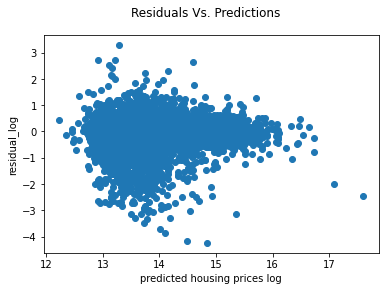

In [208]:
# linearity 

final_model_preds = final_results.predict(sm.add_constant(X_final))
# resid = error (differecne from real points (y) to predict points (preds))
final_resids = y_scld - final_model_preds

fig, ax = plt.subplots()

ax.scatter(final_model_preds, final_resids)
ax.set_xlabel('predicted housing prices log')
ax.set_ylabel('residual_log')
plt.suptitle('Residuals Vs. Predictions');

#Negative means overestimating, diff between actual and pred
#Positive means underestimating,

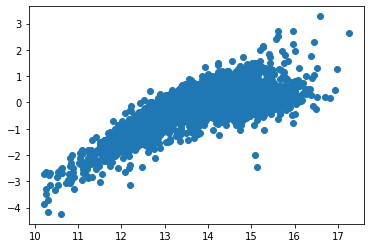

In [209]:
fig, ax = plt.subplots()

ax.scatter(y_scld, final_resids);

The Durbin-Watson test statistic is calculated on the null hypothesis that there is no correlation among the errors. The test statistic has a range of 0 to 4, where 2 indicates no correlation, a score less than 2 indicates a positive correlation, and a score greater than 2 indicates a negative correlation.

In [210]:
dw = sm.stats.stattools.durbin_watson
dw(final_resids)

1.9658280520692932

### Normality
The errors are normally distributed. That is, smaller errors are more probable than larger errors, according to the familiar bell curve. This is basically a conseqence of the Central Limit Theorem. If an error is a sum of influences from a large collection of (untracked!) variables, then the CLT assures us that that sum will have a normal distribution, regardless of the distributions of the untracked variables themselves.

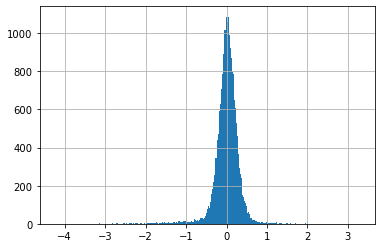

In [211]:
final_resids.hist(bins='auto');

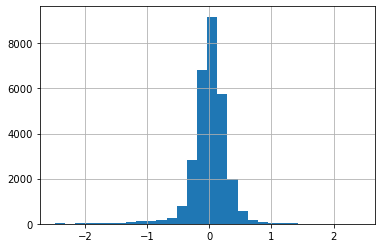

In [212]:
# To eliminate the outliers from the plot we might try zooming in on the center:
final_resids[abs(final_resids) < 2.5].hist(bins=30);

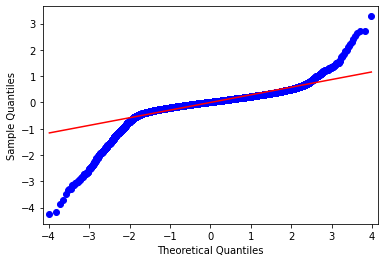

In [213]:
sm.qqplot(final_resids, line='r');

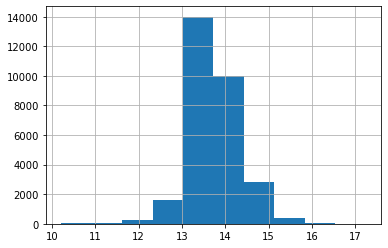

In [214]:
y_scld.hist();

In [215]:
np.exp(13)

442413.3920089205

### Homoskedasticity

Errors are homoskedatic = the errors have the same variance.

If errors are not homoskedastic, betas will have larger errors, leading to a greater risk of false negative conclusions about the significance of variables.

To check, make a scatter plot of the residuals and target values and look to see if they are more or less spread out at different places

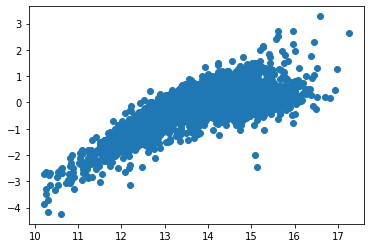

In [216]:
fig, ax = plt.subplots()

ax.scatter(y_scld, final_resids);

In [217]:
#sm.graphics.plot_regress_exog(final_results, 'X_final', fig=plt.figure(figsize=(12, 8)));

In [218]:
# for model slide, y_pred vs y_actual

## Interpreting our coeficients for our final MLR

In [219]:
p_value = []
for x in range (0, 110):
    p_value.append(final_results.pvalues[x])

p_value

[0.0,
 0.013912555438480644,
 4.648567504573697e-07,
 0.0,
 4.9179237529914e-48,
 3.4530267218371775e-215,
 1.7328823142360754e-13,
 6.34902036256353e-51,
 0.036987206254950375,
 0.0013512965195709512,
 0.026057378011252273,
 0.0006479049242928733,
 8.331844391458471e-07,
 0.003411417277102994,
 0.00107263003470549,
 0.005594414563858672,
 0.06898412082497951,
 0.5587145299161926,
 0.20590725772047697,
 7.990473466233161e-235,
 4.000633909491852e-245,
 1.7169669276616644e-237,
 2.51589534999938e-10,
 7.7846504532197785e-31,
 2.431595523899164e-62,
 7.839324052764412e-48,
 2.3009835929754013e-53,
 3.192371481181635e-186,
 3.1897689621738647e-85,
 4.8852482981854475e-119,
 6.957574562200776e-122,
 5.778930693421755e-220,
 6.3557551714503185e-245,
 4.727280383074866e-65,
 5.405622915399728e-88,
 3.5981364693046524e-107,
 2.3770682042697636e-67,
 5.059104455653073e-215,
 6.894227997027174e-219,
 8.161674640299958e-191,
 7.241338101079864e-33,
 3.366336000264367e-76,
 4.21351047026666e-181,

In [220]:
final_results.params

const                                    14.37
bedrooms                                  0.01
bathrooms                                 0.02
sqft_living                               0.00
view_AVERAGE                              0.12
                             ...              
zipcode_98663                            -1.28
zipcode_99202                            -1.04
zipcode_99203                            -1.09
zipcode_99223                            -1.02
zipcode_99403                            -1.06
Length: 110, dtype: float64

In [221]:
mlr_stats = pd.DataFrame(final_results.params, columns=['coef'])
mlr_stats

,coef
const,14.37
bedrooms,0.01
bathrooms,0.02
sqft_living,0.00
view_AVERAGE,0.12
...,...
zipcode_98663,-1.28
zipcode_99202,-1.04
zipcode_99203,-1.09
zipcode_99223,-1.02


In [222]:
mlr_stats['p_value'] = p_value

In [223]:
mlr_stats.reset_index(inplace=True)

In [224]:
mlr_stats['stat_sig']= mlr_stats['p_value'] < 0.05

For every one-unit increase in the independent variable, our dependent variable increases by about (coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9) 22%.

For every unit increase in sqft living, our price will increase by about 


In [225]:
#while mlr_stats.index <5:
 #   for i in mlr_stats['index']:
  #      print(i)
    # print(f'For every unit increase in {mlr_stats.index[0:5]})

In [226]:
mlr_stats

,index,coef,p_value,stat_sig
0,const,14.37,0.00,True
1,bedrooms,0.01,0.01,True
2,bathrooms,0.02,0.00,True
3,sqft_living,0.00,0.00,True
4,view_AVERAGE,0.12,0.00,True
...,...,...,...,...
105,zipcode_98663,-1.28,0.00,True
106,zipcode_99202,-1.04,0.00,True
107,zipcode_99203,-1.09,0.00,True
108,zipcode_99223,-1.02,0.00,True


- sqft living
- zipcode (top 10 most negative coef)



In [227]:
cat_df

,id,price,bedrooms,bathrooms,sqft_living,yr_sold,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,...,zipcode_98338,zipcode_98354,zipcode_98372,zipcode_98387,zipcode_98422,zipcode_98663,zipcode_99202,zipcode_99203,zipcode_99223,zipcode_99403
0,7399300360,"675,000.00",4,1.00,1180,2022,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8910500230,"920,000.00",5,2.50,2770,2021,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1180000275,"311,000.00",6,2.00,2880,2021,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1604601802,"775,000.00",3,3.00,2160,2021,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8562780790,"592,500.00",2,2.00,1120,2021,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,"1,555,000.00",5,2.00,1910,2021,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30151,194000695,"1,313,000.00",3,2.00,2020,2021,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
30152,7960100080,"800,000.00",3,2.00,1620,2022,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30153,2781280080,"775,000.00",3,2.50,2570,2022,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
np.exp(0.0002)

1.0002000200013335

''

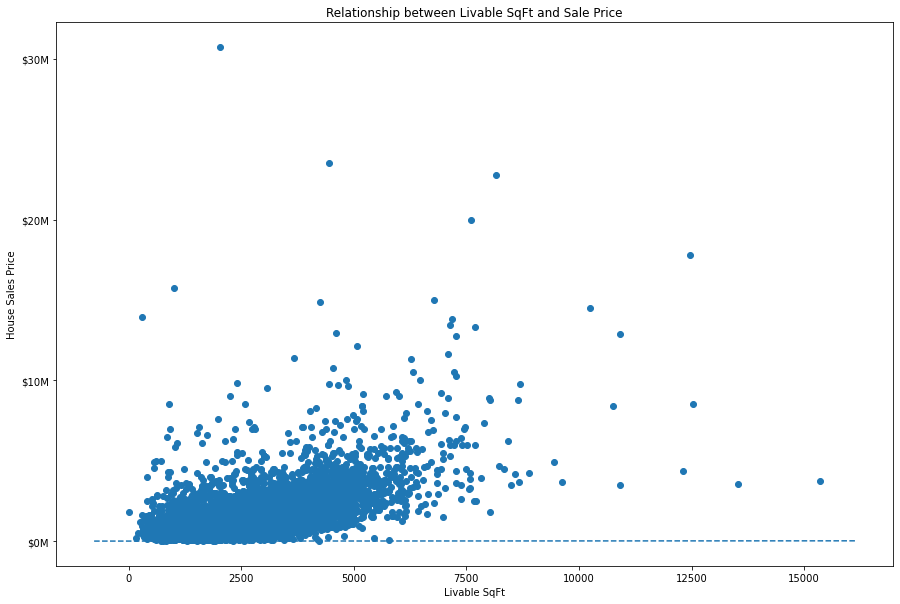

In [229]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(cat_df['sqft_living'],cat_df['price'])

_y_ticks = [(value * 10**7) for value in range(0,4,1)]
ax.set(
    title = "Relationship between Livable SqFt and Sale Price", 
    ylabel = "House Sales Price",
    xlabel = "Livable SqFt",
    yticks=_y_ticks,
    yticklabels = [f'${int(x/1000000):,}M' for x in _y_ticks]
)
sqft = np.exp(0.0002)
abline(sqft,0)
; 

In [230]:
cat_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,yr_sold,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,...,zipcode_98338,zipcode_98354,zipcode_98372,zipcode_98387,zipcode_98422,zipcode_98663,zipcode_99202,zipcode_99203,zipcode_99223,zipcode_99403
count,"29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00",...,"29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00","29,242.00"
mean,"4,535,666,102.76","1,112,507.16",3.44,2.33,"2,130.73","2,021.36",0.06,0.02,0.01,0.03,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,"2,881,941,622.12","895,237.86",0.98,0.90,977.22,0.48,0.25,0.14,0.09,0.17,...,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
min,"1,000,055.00","27,360.00",0.00,0.00,3.00,"2,021.00",0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"2,085,200,937.50","645,000.00",3.00,2.00,"1,440.00","2,021.00",0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"3,870,400,142.50","867,000.00",3.00,2.50,"1,940.00","2,021.00",0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,"7,286,950,019.00","1,310,000.00",4.00,3.00,"2,640.00","2,022.00",0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,"9,904,000,012.00","30,750,000.00",13.00,10.50,"15,360.00","2,022.00",1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [231]:
#Graph for grade, groupby grade, median price

grade_df = pd.DataFrame(clean_houses.groupby('grade').median()['price'].sort_values())
grade_df.reset_index(inplace=True)
grade_df['stat_sig'] = [True,True,True,True,True,False,False,False,True,True,True,True]
grade_df
#[x for x in mlr_stats['stat_sig'] if grade_df['grade'] in mlr_stats['index']]


,grade,price,stat_sig
0,2 Substandard,"302,500.00",True
1,3 Poor,"400,000.00",True
2,4 Low,"470,000.00",True
3,5 Fair,"500,000.00",True
4,6 Low Average,"575,000.00",True
5,7 Average,"750,000.00",False
6,8 Good,"950,000.00",False
7,9 Better,"1,499,950.00",False
8,10 Very Good,"2,180,000.00",True
9,11 Excellent,"2,950,000.00",True


''

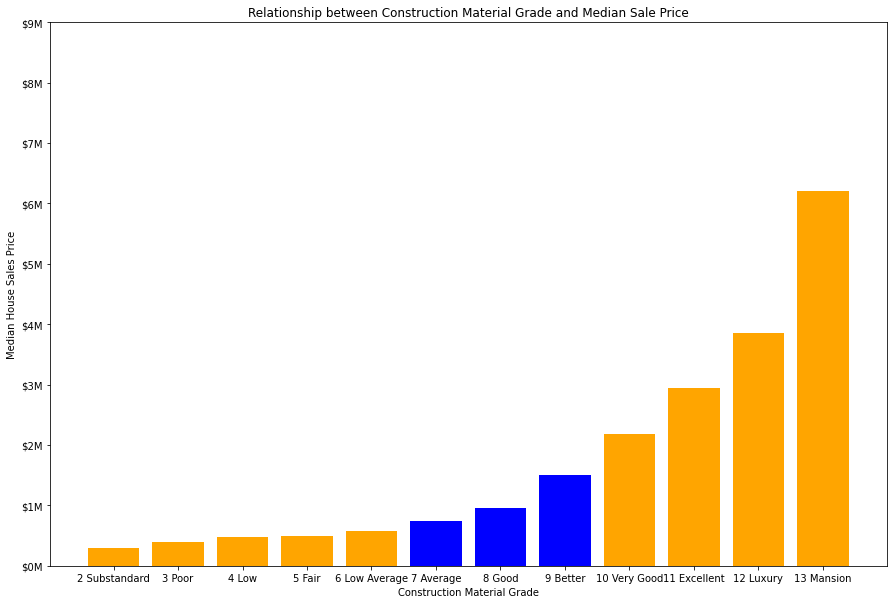

In [232]:
fig, ax = plt.subplots(figsize=(15,10))

colors = ["orange" if i == True else "blue" for i in grade_df['stat_sig']]
ax.bar(x=grade_df['grade'],height=grade_df['price'], color=colors)
_y_ticks = [(value * 10**6) for value in range(0,10)]
ax.set(
    title = "Relationship between Construction Material Grade and Median Sale Price", 
    ylabel = "Median House Sales Price",
    xlabel = "Construction Material Grade",
    yticks=_y_ticks,
    yticklabels = [f'${int(x/1000000):,}M' for x in _y_ticks]
)
;
#Add lines to make it visually easy to see pricing per grade, add theme at the beginning
# and see if there's a color code.

In [233]:
mlr_stats.sort_values(by='coef').head(10)

,index,coef,p_value,stat_sig
104,zipcode_98422,-2.40,0.00,True
93,zipcode_98224,-2.07,0.00,True
98,zipcode_98288,-1.64,0.00,True
20,zipcode_98002,-1.56,0.00,True
46,zipcode_98047,-1.52,0.00,True
21,zipcode_98003,-1.51,0.00,True
32,zipcode_98023,-1.50,0.00,True
19,zipcode_98001,-1.48,0.00,True
62,zipcode_98092,-1.47,0.00,True
90,zipcode_98198,-1.46,0.00,True


In [234]:
zip_df = pd.DataFrame(clean_houses.groupby(['zipcode','yr_sold']).median()['price'])
zip_df#.plt.bar() #== ['98422','98244','98288','98002','98047','98003','98023','98001','98092','98198']]

price
zipcode yr_sold                               
98001   2021                        575,000.00
        2022                        650,000.00
98002   2021                        455,000.00
        2022                        505,000.00
98003   2021                        540,000.00
...                                        ...
98663   2021                        597,450.00
99202   2021                        759,950.00
99203   2022                        679,950.00
99223   2022                        879,000.00
99403   2021                        789,995.00

[171 rows x 1 columns]

In [235]:
f, a = plt.subplots(3,1)
df.xs('A').plot(kind='bar',ax=a[0])
df.xs('B').plot(kind='bar',ax=a[1])
df.xs('C').plot(kind='bar',ax=a[2])

#fig, ax = plt.subplots()

#ax.bar(x=zip_df.index,height=zip_df['price']);

In [236]:
zip_df_2 = pd.DataFrame(clean_houses.groupby('zipcode').median()['price'])
zip_df_2.reset_index(inplace=True)
zip_median = zip_df_2.loc[(zip_df_2['zipcode'] == '98422') | (zip_df_2['zipcode'] == '98288') | (zip_df_2['zipcode'] == '98002') | (zip_df_2['zipcode'] == '98047') | (zip_df_2['zipcode'] == '98003')| (zip_df_2['zipcode'] == '98023') | (zip_df_2['zipcode'] == '98001') | (zip_df_2['zipcode'] == '98092') | (zip_df_2['zipcode'] == '98198')]
zip_median = zip_median.sort_values(by='price')
zip_median

,zipcode,price
86,98422,"312,750.00"
80,98288,"380,000.00"
1,98002,"470,000.00"
28,98047,"500,000.00"
2,98003,"550,000.00"
72,98198,"575,000.00"
13,98023,"590,000.00"
0,98001,"600,000.00"
44,98092,"675,000.00"


''

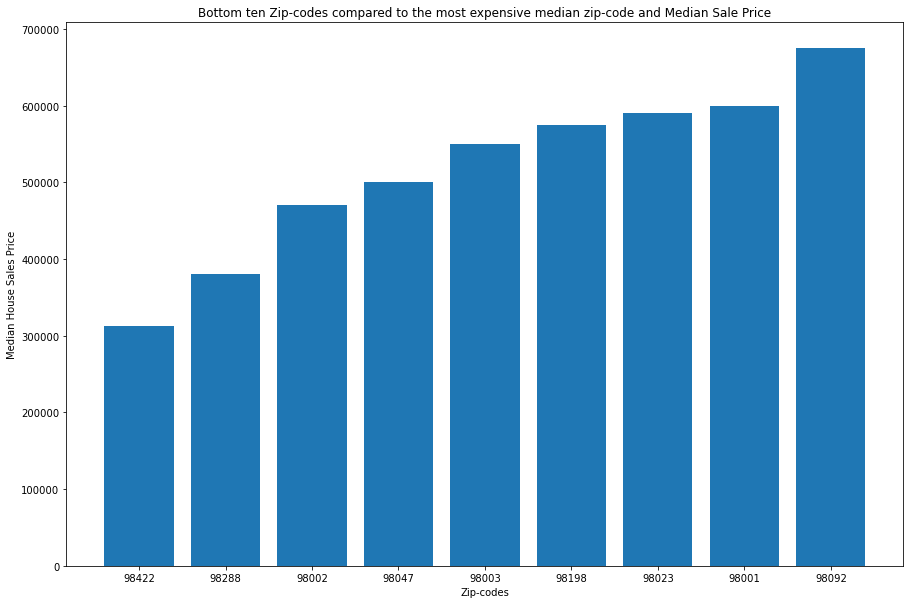

In [237]:
fig, ax = plt.subplots(figsize=(15,10))

ax.bar(x=zip_median['zipcode'],height=zip_median['price'])

ax.set(
    title = "Bottom ten Zip-codes compared to the most expensive median zip-code and Median Sale Price", 
    ylabel = "Median House Sales Price",
    xlabel = "Zip-codes")
;